# 04 - Unsupervised
Quick prototypes for LDA, NMF and visual validation.

In [1]:
# Import functions from ../scripts
import sys
sys.path.append('../scripts')
from utils import load_data, preprocess_data

In [2]:
# just testing
unsupervisedDF = load_data()

In [3]:
# just testing
proc_df = preprocess_data(unsupervisedDF)
proc_df['Sentiment'].value_counts()

Sentiment
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

In [ ]:
proc_df.head()

,ID,Entity,Sentiment,Tweet,hashtags,mentions,tokens,lemmas,processed_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,,,"[im, getting, borderlands, murder]","[im, get, borderland, murder]",im get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,,,"[coming, borders, kill]","[come, border, kill]",come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,,,"[im, getting, borderlands, kill]","[im, get, borderland, kill]",im get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,,,"[im, coming, borderlands, murder]","[im, come, borderland, murder]",im come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,,,"[im, getting, borderlands, 2, murder]","[im, get, borderland, 2, murder]",im get borderland 2 murder


In [ ]:
proc_df.shape

(73996, 9)

In [12]:
df=proc_df

In [ ]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import spacy

# vectorizers & models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# persistence & viz
import joblib
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load small spacy model if available (for lemmatization)
try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
except:
    nlp = None  # if missing, run: python -m spacy download en_core_web_sm


assert 'processed_text'in df.columns, "CSV must have a 'text' column"
texts = df['processed_text'].astype(str).tolist()


tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False)

EN_STOP = set(stopwords.words('english'))
TW_STOP = set(['rt','https','http','co'])
STOPWORDS = EN_STOP.union(TW_STOP)

url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#\w+')
emoji_re = re.compile("[" 
         u"\U0001F600-\U0001F64F"
         u"\U0001F300-\U0001F5FF"
         u"\U0001F680-\U0001F6FF"
                           "]+", flags=re.UNICODE)

def clean_tweet(text):
    text = str(text)
    text = url_re.sub(' ', text)
    text = mention_re.sub(' ', text)
    text = re.sub(r'#', ' #', text)
    text = emoji_re.sub(' ', text)
    text = re.sub(r'[^A-Za-z0-9# ]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def preprocess_tokens(text, lemmatize=True, nlp=nlp):
    txt = clean_tweet(text)
    tokens = tknzr.tokenize(txt)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 2]
    tokens = [t[1:] if t.startswith('#') else t for t in tokens]
    if lemmatize and nlp:
        doc = nlp(" ".join(tokens))
        tokens = [tok.lemma_ for tok in doc if tok.lemma_ not in STOPWORDS and len(tok.lemma_) > 2]
    return tokens

tokenized = [preprocess_tokens(t) for t in tqdm(texts, desc="Preprocessing")]
joined_docs = [" ".join(toks) for toks in tokenized]

tfidf = TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1,2), max_features=30000)
X_tfidf = tfidf.fit_transform(joined_docs)

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
kmeans_labels = kmeans.fit_predict(X_tfidf)

try:
    s = silhouette_score(X_tfidf, kmeans_labels, sample_size=2000, random_state=42)
except:
    s = silhouette_score(X_tfidf.toarray()[:2000], kmeans_labels[:2000])
print(f"KMeans silhouette (sampled): {s:.4f}")

def top_terms_per_cluster(kmeans_model, vectorizer, topn=12):
    centers = kmeans_model.cluster_centers_
    terms = vectorizer.get_feature_names_out()
    top = []
    for i, center in enumerate(centers):
        idx = np.argsort(center)[::-1][:topn]
        top.append([terms[j] for j in idx])
    return top

cluster_top = top_terms_per_cluster(kmeans, tfidf, topn=12)
for i, terms in enumerate(cluster_top):
    print(f"Cluster {i}: {', '.join(terms[:8])}")


count_vect = CountVectorizer(max_df=0.95, min_df=5, ngram_range=(1,2), max_features=30000)
X_counts = count_vect.fit_transform(joined_docs)

dictionary = Dictionary(tokenized)
dictionary.filter_extremes(no_below=5, no_above=0.95, keep_n=30000)
corpus_gensim = [dictionary.doc2bow(doc) for doc in tokenized]

lda_models = {}
coherence_scores = {}
for n_topics in range(15, 21):
    print(f"Training LDA: {n_topics} topics ...")
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42, batch_size=1024)
    lda.fit(X_counts)
    lda_models[n_topics] = lda

    topics_words = []
    for topic_idx, topic in enumerate(lda.components_):
        topn = topic.argsort()[::-1][:15]
        topic_terms = [count_vect.get_feature_names_out()[i] for i in topn]
        topics_words.append(topic_terms)

    cm = CoherenceModel(topics=topics_words, texts=tokenized, dictionary=dictionary, coherence='c_v')
    coherence_scores[n_topics] = cm.get_coherence()
    print(f" -> coherence (c_v): {coherence_scores[n_topics]:.4f}")

best_n = max(coherence_scores, key=coherence_scores.get)
lda = lda_models[best_n]
print("Best number of topics by coherence:", best_n, coherence_scores[best_n])


n_nmf = 15
nmf = NMF(n_components=n_nmf, random_state=42, init='nndsvda', max_iter=400)
W = nmf.fit_transform(X_tfidf)
H = nmf.components_

df['kmeans_label'] = kmeans_labels
doc_topic_lda = lda.transform(X_counts)
df['lda_topic'] = np.argmax(doc_topic_lda, axis=1)
df['nmf_topic'] = np.argmax(W, axis=1)

joblib.dump({'tfidf': tfidf, 'count_vect': count_vect, 'kmeans': kmeans, 'lda': lda, 'nmf': nmf}, "models.joblib")

print(" Finished topic modeling and saved models. You can now explore 'tweets_with_topics.csv'.")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\test\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\test\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\test\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Preprocessing:   0%|          | 0/73996 [00:00<?, ?it/s]

Preprocessing: 100%|██████████| 73996/73996 [00:17<00:00, 4197.92it/s]


KMeans silhouette (sampled): 0.0126
Cluster 0: dead, red, red dead, redemption, dead redemption, access health, time, time commission
Cluster 1: fuck, game, let fuck, shit, fuck fuck, let, fifa, get
Cluster 2: like, look, look like, get, game, really, feel, play
Cluster 3: get, good, johnson, shit, one, make, new, great
Cluster 4: love, game, love see, much, new, show, see, show love
Cluster 5: ban, player, detail, see detail, occur, occur see, battlefield player, battlefield
Cluster 6: game, play, cant, wait, get, cant wait, good, fix
Cluster 7: depot, home, home depot, work, walmart, lowes, depot get, get
Cluster 8: unk, unk unk, welcome, cool, haha, life, youtube, win
Cluster 9: best, ever, game, best game, one best, one, play, player
Training LDA: 15 topics ...
 -> coherence (c_v): 0.3885
Training LDA: 16 topics ...
 -> coherence (c_v): 0.4042
Training LDA: 17 topics ...
 -> coherence (c_v): 0.3930
Training LDA: 18 topics ...
 -> coherence (c_v): 0.4047
Training LDA: 19 topics ...


In [16]:
df

,ID,Entity,Sentiment,Tweet,hashtags,mentions,tokens,lemmas,processed_text,kmeans_label,lda_topic,nmf_topic
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,,,"[im, getting, borderlands, murder]","[im, get, borderland, murder]",im get borderland murder,3,17,0
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,,,"[coming, borders, kill]","[come, border, kill]",come border kill,3,17,0
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,,,"[im, getting, borderlands, kill]","[im, get, borderland, kill]",im get borderland kill,3,12,0
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,,,"[im, coming, borderlands, murder]","[im, come, borderland, murder]",im come borderland murder,3,12,0
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,,,"[im, getting, borderlands, 2, murder]","[im, get, borderland, 2, murder]",im get borderland 2 murder,3,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...
73991,9200,Nvidia,Positive,Just realized that the Windows partition of my...,,,"[realized, windows, partition, mac, like, 6, y...","[realize, window, partition, mac, like, 6, yea...",realize window partition mac like 6 year behin...,2,2,0
73992,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,,,"[realized, mac, window, partition, 6, years, b...","[realize, mac, window, partition, 6, year, beh...",realize mac window partition 6 year behind nvi...,3,2,0
73993,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,,,"[realized, windows, partition, mac, 6, years, ...","[realize, window, partition, mac, 6, year, beh...",realize window partition mac 6 year behind nvi...,3,2,0
73994,9200,Nvidia,Positive,Just realized between the windows partition of...,,,"[realized, windows, partition, mac, like, 6, y...","[realize, window, partition, mac, like, 6, yea...",realize window partition mac like 6 year behin...,2,2,3


In [17]:
df['kmeans_label'].value_counts()

kmeans_label
3    50569
6     9658
2     3835
4     2306
1     2001
9     1948
0     1855
7     1022
5      458
8      344
Name: count, dtype: int64

In [18]:
import seaborn as sns

c:\Users\test\anacondaaaaa\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\test\anacondaaaaa\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\test\anacondaaaaa\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: xlabel='kmeans_label', ylabel='count'>

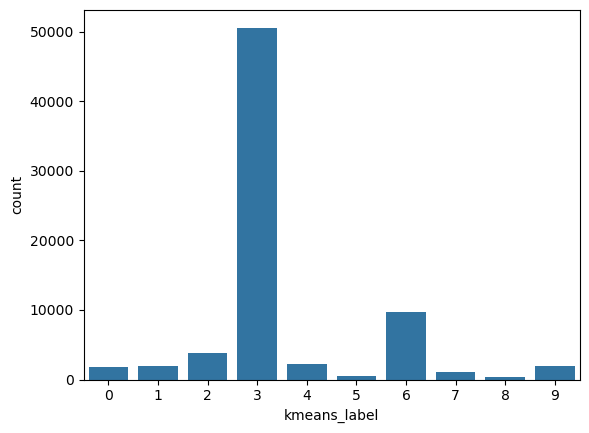

In [19]:
sns.countplot(x='kmeans_label',data=df)